In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/My Drive/Studies 2/Year 2/Semester A/Deep Learning/HW/hw4'

/content/gdrive/My Drive/Studies 2/Year 2/Semester A/Deep Learning/HW/hw4


$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\cset}[1]{\mathcal{#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\E}[2][]{\mathbb{E}_{#1}\left[#2\right]}
\newcommand{\ip}[3]{\left<#1,#2\right>_{#3}}
\newcommand{\given}[]{\,\middle\vert\,}
\newcommand{\DKL}[2]{\cset{D}_{\text{KL}}\left(#1\,\Vert\, #2\right)}
\newcommand{\grad}[]{\nabla}
$$

# Part 4: Mini-Project
<a id=part3></a>

In this part you'll implement a small comparative-analysis project, heavily based on the materials from the tutorials and homework.

### Guidelines

- You should implement the code which displays your results in this notebook, and add any additional code files for your implementation in the `project/` directory. You can import these files here, as we do for the homeworks.
- Running this notebook should not perform any training - load your results from some output files and display them here. The notebook must be runnable from start to end without errors.
- You must include a detailed write-up (in the notebook) of what you implemented and how. 
- Explain the structure of your code and how to run it to reproduce your results.
- Explicitly state any external code you used, including built-in pytorch models and code from the course tutorials/homework.
- Analyze your numerical results, explaining **why** you got these results (not just specifying the results).
- Where relevant, place all results in a table or display them using a graph.
- Before submitting, make sure all files which are required to run this notebook are included in the generated submission zip.
- Try to keep the submission file size under 10MB. Do not include model checkpoint files, dataset files, or any other non-essentials files. Instead include your results as images/text files/pickles/etc, and load them for display in this notebook. 

## Spectrally-Normalized Wasserstein GANs

One of the prevailing approaches for improving training stability for GANs is to use a technique called [Spectral Normalization](https://arxiv.org/pdf/1802.05957.pdf) to normalize the largest singular value of a weight matrix so that it equals 1.
This approach is generally applied to the discriminator's weights in order to stabilize training. The resulting model is sometimes referred to as a SN-GAN.
See Appendix A in the linked paper for the exact algorithm. You can also use pytorch's `spectral_norm`.

Another very common improvement to the vanilla GAN is known a [Wasserstein GAN](https://arxiv.org/pdf/1701.07875.pdf) (WGAN). It uses a simple modification to the loss function, with strong theoretical justifications based on the Wasserstein (earth-mover's) distance.
See the tutorial or [here](https://developers.google.com/machine-learning/gan/loss) for a brief explanation of this loss function.

One problem with generative models for images is that it's difficult to objectively assess the quality of the resulting images.
To also obtain a quantitative score for the images generated by each model,
we'll use the [Inception Score](https://arxiv.org/pdf/1606.03498.pdf).
This uses a pre-trained Inception CNN model on the generated images and computes a score based on the predicted probability for each class.
Although not a perfect proxy for subjective quality, it's commonly used a way to compare generative models.
You can use an implementation of this score that you find online, e.g. [this one](https://github.com/sbarratt/inception-score-pytorch) or implement it yourself.

You would gain a **Bonus** if you also adress [Gradient Penalty](https://arxiv.org/pdf/1704.00028.pdf), as we saw in the tutorial that it could improve the robustness of the GAN and essentially improve the results


Based on the linked papers, add Spectral Normalization and the Wassertein loss to your GAN from HW3.
Compare between:
- The baseline model (vanilla GAN)
- SN-GAN (vanilla + Spectral Normalization)
- WGAN (using Wasserstein Loss)
- Optional: SN+WGAN, i.e. a combined model using both modifications.
- Bonus: WGAN+GP and SN+WGAN+GP

As a dataset, you can use [LFW](http://vis-www.cs.umass.edu/lfw/) as in HW3 or [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), or even choose a custom dataset (note that there's a dataloder for CelebA in `torchvision`). 

Your results should include:
- Everything written in the **Guidelines** above.
- A comparative analysis between the baseline and the other models. Compare:
  - Subjective quality (show multiple generated images from each model)
  - Inception score (can use a subset of the data).
- You should show substantially improved subjective visual results with these techniques.

## Implementation

**TODO**: This is where you should write your explanations and implement the code to display the results.
See guidelines about what to include in this section.

In [5]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

import cs3600.plot as plot
import cs3600.download
from hw4.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

from project.gan import *
from project.gan_dataloader import *
from project.gan_hyperparameters import *
from project.gan_training import *

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cpu


## Loading data into pytorch dataset

In [4]:
hp = gan_hyperparameters()

In [8]:
ds_train = MyDataSet()
dataset = ds_train.ds_gwb

File C:\Users\alon2\.pytorch-datasets\lfw-bush.zip exists, skipping download.
Extracting C:\Users\alon2\.pytorch-datasets\lfw-bush.zip...
Extracted 531 to C:\Users\alon2\.pytorch-datasets\lfw/George_W_Bush


{'batch_size': 8, 'z_dim': 256, 'data_label': 1, 'label_noise': 0.3, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0005}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0005}, 'n_critic': 1, 'c': 0.0}
--- EPOCH 1/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:59<00:00,  1.13it/s]
Discriminator loss: 1.2268816998867846
Generator loss:     15.144260652029692
Saved checkpoint.


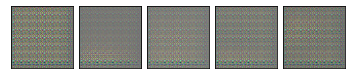

--- EPOCH 2/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [01:01<00:00,  1.09it/s]
Discriminator loss: 3.794240161998948
Generator loss:     28.849774641777152
Saved checkpoint.


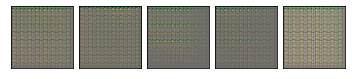

--- EPOCH 3/50 ---
 28%|███████████████████████▎                                                          | 19/67 [00:18<00:46,  1.02it/s]

 *** Training interrupted by user


In [29]:
GANTrainer = Train(name='gan',dataset=dataset, device=device).train(50)

In [7]:
hp = sngan_hyperparams()
SNGANTrainer(hp, dl_train).train(50)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
hp = wgan_hyperparams()
print(hp)
WGANTrainer(hp, dl_train).train(50)

In [ ]:
hp = w_sn_gan_hyperparams()
print(hp)
SNWGANTrainer(hp, dl_train).train(50)